In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Importing essential sklearn libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import LeaveOneOut, RepeatedStratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV, learning_curve

from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, confusion_matrix

In [29]:
#Importing only transcriptomics of the training set into data1/X1 and integrated training set into data2/X2
data1 = pd.read_csv("TrainingSet_Transcriptomics.csv")
data1.dropna(inplace=True)
X1 = data1.select_dtypes('float64')
Y1 = data1.Target

data2 = pd.read_csv("TrainingSet_Integrated.csv")
data2.dropna(inplace=True)
X2 = data2.select_dtypes('float64')
Y2 = data2.Target

#Performing both normalization and standardization 
normalizer = MinMaxScaler()
standardizer = StandardScaler()
X1_stand = standardizer.fit_transform(X1)
X1_normal = normalizer.fit_transform(X1)
X2_stand = standardizer.fit_transform(X2)
X2_normal = normalizer.fit_transform(X2)

In [31]:
#Identifying the best parameters for each model by GridSearch
model_1 = LogisticRegression()
model_2 = SVC()
model_3 = RandomForestClassifier(random_state=1)
model_4 = xgb.XGBClassifier(objective="binary:logistic", seed=1)

param_grid1 = {
    'penalty':['l1','l2','elasticnet','none'],
    'C':[0.0001, 0.001, 0.01, 0.1]}
param_grid2 = {
    'C':[0.0001, 0.001, 0.01, 0.1],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
param_grid3 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]}
param_grid4 = {
    'learning_rate' : [0.75, 0.5, 0.25, 0.1, 0.01, 0.001, 0.0001],
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 20, 30, 50]}

models = [model_1, model_2, model_3, model_4]
param_grids = [param_grid1, param_grid2, param_grid3, param_grid4]

best_estimators_trans, best_estimators_integ = [],[]

for i in range(4):
    models[i].fit(X1_stand, Y1)
    clf = GridSearchCV(models[i], param_grid = param_grids[i], cv=10, n_jobs=-1)
    best_clf = clf.fit(X1_stand, Y1)
    best_estimators_trans.append(best_clf.best_estimator_)

for i in range(4):
    models[i].fit(X2_stand, Y2)
    clf = GridSearchCV(models[i], param_grid = param_grids[i], cv=10, n_jobs=-1)
    best_clf = clf.fit(X2_stand, Y2)
    best_estimators_integ.append(best_clf.best_estimator_)

mods = ["LogisticRegression", "SVM", "RandomForest", "XGB"]
for i in range(4):
    print(f'Best {mods[i]} for Transcriptomics data : {best_estimators_trans[i]}')
    print(f'Best {mods[i]} for Integrated data : {best_estimators_integ[i]}')

Best LogisticRegression for Transcriptomics data : LogisticRegression(C=0.01)
Best LogisticRegression for Integrated data : LogisticRegression(C=0.1)
Best SVM for Transcriptomics data : SVC(C=0.1, kernel='linear')
Best SVM for Integrated data : SVC(C=0.1, kernel='linear')
Best RandomForest for Transcriptomics data : RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=1)
Best RandomForest for Integrated data : RandomForestClassifier(bootstrap=False, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=50, random_state=1)
Best XGB for Transcriptomics data : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
   

In [65]:
#Setting the parameters according to what was obtained in GridSearch
model_1 = LogisticRegression(C=0.01)
model_2 = SVC(C=0.1, kernel='linear', probability=True)
model_3 = RandomForestClassifier(random_state=1, min_samples_leaf=2, 
                                 min_samples_split=10, n_estimators=50)
model_4 = xgb.XGBClassifier(objective="binary:logistic", seed=1, 
                            learning_rate=0.75, n_estimators=200)

#Setting the parameters for cross-validation
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
n_jobs = -1
error_score = 'raise'

In [67]:
#Performing KFold cross-validation with all eight (4x2) models
models = [model_1, model_2, model_3, model_4]
kfold1, kfold2 = [], []

for y in scoring:
    for x in models:
        score1 = cross_val_score(x, X1_stand, Y1, scoring=y, cv=cv, n_jobs=n_jobs, error_score=error_score)
        score2 = cross_val_score(x, X2_stand, Y2, scoring=y, cv=cv, n_jobs=n_jobs, error_score=error_score)
        kfold1.append('%.3f (%.3f)' % (np.mean(score1), np.std(score1)))
        kfold2.append('%.3f (%.3f)' % (np.mean(score2), np.std(score2)))

methods = ['LogisticRegression', 'SVM', 'RandomForest', 'XGBoost']
trans = pd.DataFrame({'Model':methods, 'Accuracy':kfold1[0:4], 'F1 Score':kfold1[4:8], 'Precision':kfold1[8:12],
                      'Recall':kfold1[12:16], 'ROC AUC':kfold1[16:20]})
integ = pd.DataFrame({'Model':methods, 'Accuracy':kfold2[0:4], 'F1 Score':kfold2[4:8], 'Precision':kfold2[8:12],
                      'Recall':kfold2[12:16], 'ROC AUC':kfold2[16:20]})

print('Performance of Models with only Transcriptomics data')
print(trans)
print('Performance of Models with Integrated data')
print(integ)

Performance of Models with only Transcriptomics data
                Model       Accuracy       F1 Score      Precision  \
0  LogisticRegression  0.626 (0.168)  0.568 (0.212)  0.692 (0.206)   
1                 SVM  0.605 (0.135)  0.507 (0.170)  0.707 (0.201)   
2        RandomForest  0.752 (0.120)  0.751 (0.105)  0.784 (0.138)   
3             XGBoost  0.745 (0.123)  0.754 (0.107)  0.752 (0.134)   

          Recall        ROC AUC  
0  0.531 (0.245)  0.720 (0.147)  
1  0.427 (0.192)  0.734 (0.117)  
2  0.732 (0.111)  0.814 (0.090)  
3  0.772 (0.122)  0.778 (0.129)  
Performance of Models with Integrated data
                Model       Accuracy       F1 Score      Precision  \
0  LogisticRegression  0.775 (0.154)  0.814 (0.140)  0.744 (0.188)   
1                 SVM  0.795 (0.158)  0.812 (0.176)  0.794 (0.221)   
2        RandomForest  0.804 (0.113)  0.822 (0.108)  0.827 (0.174)   
3             XGBoost  0.824 (0.110)  0.837 (0.130)  0.810 (0.155)   

          Recall        ROC AUC 

In [37]:
trans

,Model,Accuracy,F1 Score,Precision,Recall,ROC AUC
0,LogisticRegression,0.626 (0.168),0.568 (0.212),0.692 (0.206),0.531 (0.245),0.720 (0.147)
1,SVM,0.605 (0.135),0.507 (0.170),0.707 (0.201),0.427 (0.192),0.734 (0.117)
2,RandomForest,0.752 (0.120),0.751 (0.105),0.784 (0.138),0.732 (0.111),0.814 (0.090)
3,XGBoost,0.745 (0.123),0.754 (0.107),0.752 (0.134),0.772 (0.122),0.778 (0.129)


In [39]:
integ

,Model,Accuracy,F1 Score,Precision,Recall,ROC AUC
0,LogisticRegression,0.775 (0.154),0.814 (0.140),0.744 (0.188),0.926 (0.095),0.844 (0.159)
1,SVM,0.795 (0.158),0.812 (0.176),0.794 (0.221),0.847 (0.143),0.843 (0.141)
2,RandomForest,0.804 (0.113),0.822 (0.108),0.827 (0.174),0.840 (0.092),0.874 (0.116)
3,XGBoost,0.824 (0.110),0.837 (0.130),0.810 (0.155),0.882 (0.154),0.882 (0.114)


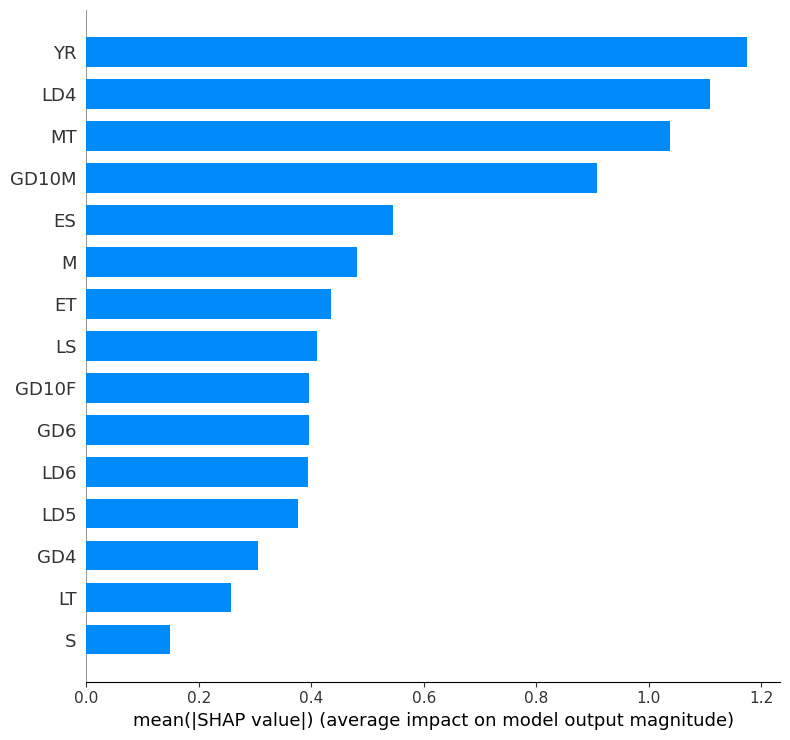

In [41]:
#Ranking the features in Transcriptomics only data for XGBClassifier with Shap
X1_stand_df = pd.DataFrame(X1_stand, columns=X1.columns)
X_train, X_test, y_train, y_test = train_test_split(X1_stand_df, Y1, test_size=0.2,
                                                    random_state=1)
model_4.fit(X_train, y_train)
explainer = shap.Explainer(model_4)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

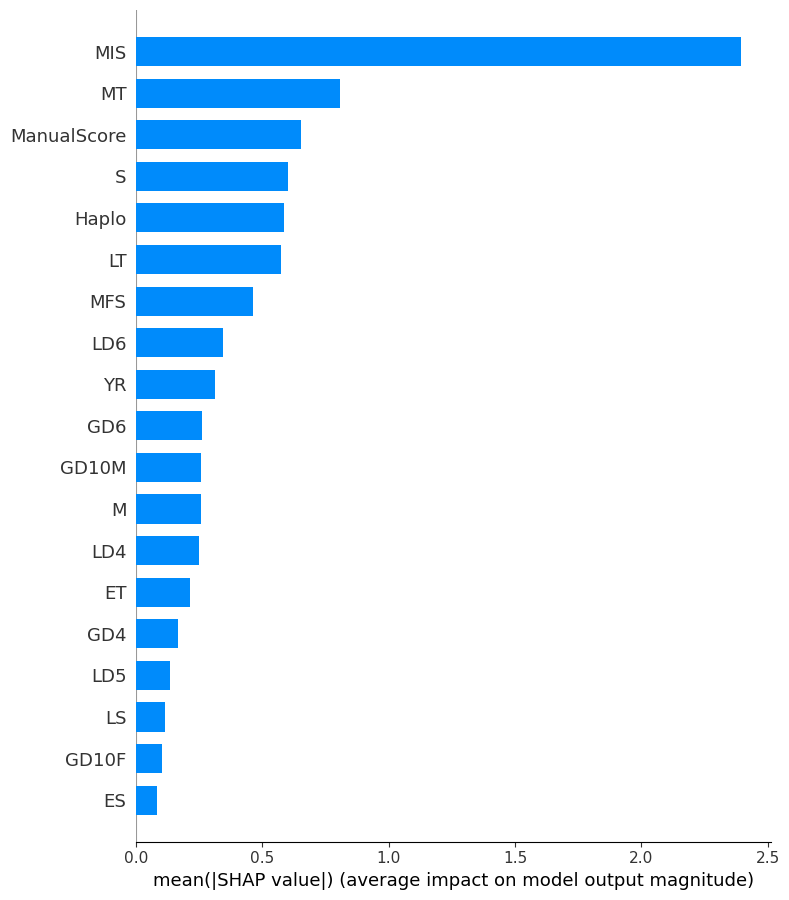

In [43]:
#Ranking the features in Integrated data for XGBClassifier with Shap
X2_stand_df = pd.DataFrame(X2_stand, columns=X2.columns)
X_train, X_test, y_train, y_test = train_test_split(X2_stand_df, Y2, test_size=0.2,
                                                    random_state=1)
model_4.fit(X_train, y_train)
explainer = shap.Explainer(model_4)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

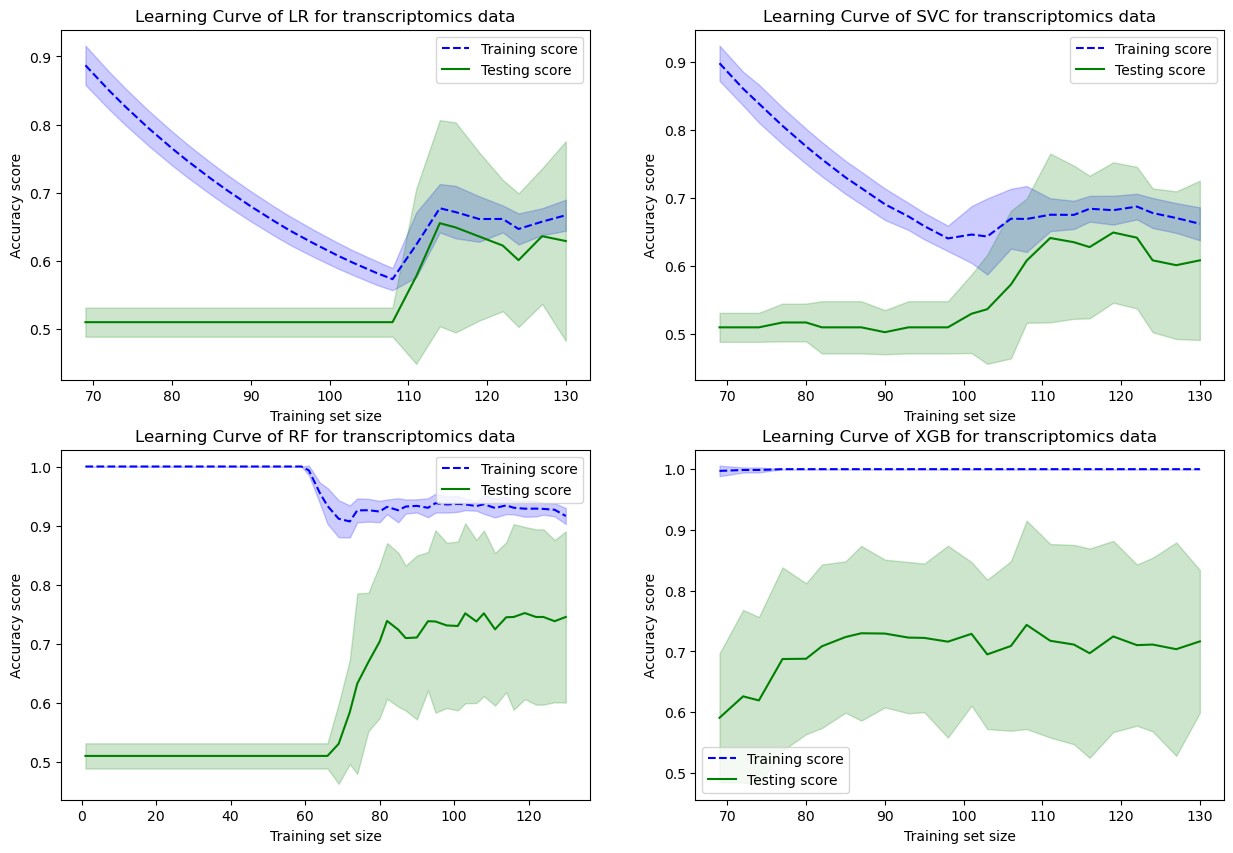

In [57]:
#Learning curves for Transcriptomics data
fig, axis = plt.subplots(2, 2, figsize=(15, 10))

mods = ["LR","SVC","RF","XGB"]
axes = [axis[0,0], axis[0,1], axis[1,0], axis[1,1]]

for i in range(4):
    sizes, training_scores, testing_scores = learning_curve(models[i], X1_stand, Y1, cv=10, scoring='accuracy', 
                                                            train_sizes=np.linspace(0.01, 1.0, 50))
    mean_training = np.mean(training_scores, axis=1)
    std_training = np.std(training_scores, axis=1)
    mean_testing = np.mean(testing_scores, axis=1)
    std_testing = np.std(testing_scores, axis=1)
    
    axes[i].plot(sizes, mean_training, '--', color="b", label="Training score")
    axes[i].fill_between(sizes, mean_training + std_training, mean_training - std_training, color="b", alpha=0.2)
    axes[i].plot(sizes, mean_testing, color="g", label="Testing score")
    axes[i].fill_between(sizes, mean_testing + std_testing, mean_testing - std_testing, color="g", alpha=0.2)
    axes[i].set_xlabel("Training set size")
    axes[i].set_ylabel("Accuracy score")
    axes[i].set_title(f'Learning Curve of {mods[i]} for transcriptomics data')
    axes[i].legend(loc="best")

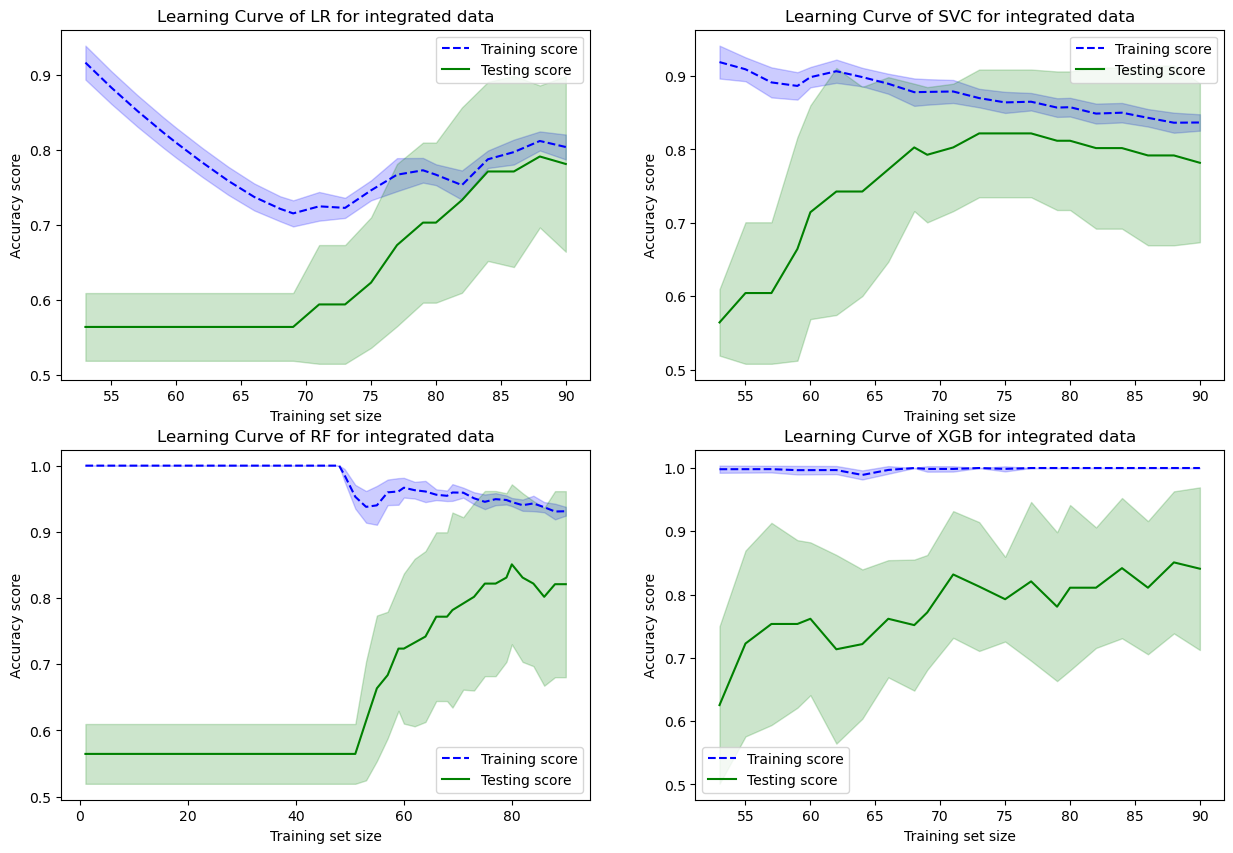

In [59]:
#Learning curves for Integrated data
fig, axis = plt.subplots(2, 2, figsize=(15, 10))

mods = ["LR","SVC","RF","XGB"]
axes = [axis[0,0], axis[0,1], axis[1,0], axis[1,1]]

for i in range(4):
    sizes, training_scores, testing_scores = learning_curve(models[i], X2_stand, Y2, cv=10, scoring='accuracy', 
                                                            train_sizes=np.linspace(0.01, 1.0, 50))
    mean_training = np.mean(training_scores, axis=1)
    std_training = np.std(training_scores, axis=1)
    mean_testing = np.mean(testing_scores, axis=1)
    std_testing = np.std(testing_scores, axis=1)
    
    axes[i].plot(sizes, mean_training, '--', color="b", label="Training score")
    axes[i].fill_between(sizes, mean_training + std_training, mean_training - std_training, color="b", alpha=0.2)
    axes[i].plot(sizes, mean_testing, color="g", label="Testing score")
    axes[i].fill_between(sizes, mean_testing + std_testing, mean_testing - std_testing, color="g", alpha=0.2)
    axes[i].set_xlabel("Training set size")
    axes[i].set_ylabel("Accuracy score")
    axes[i].set_title(f'Learning Curve of {mods[i]} for integrated data')
    axes[i].legend(loc="best")

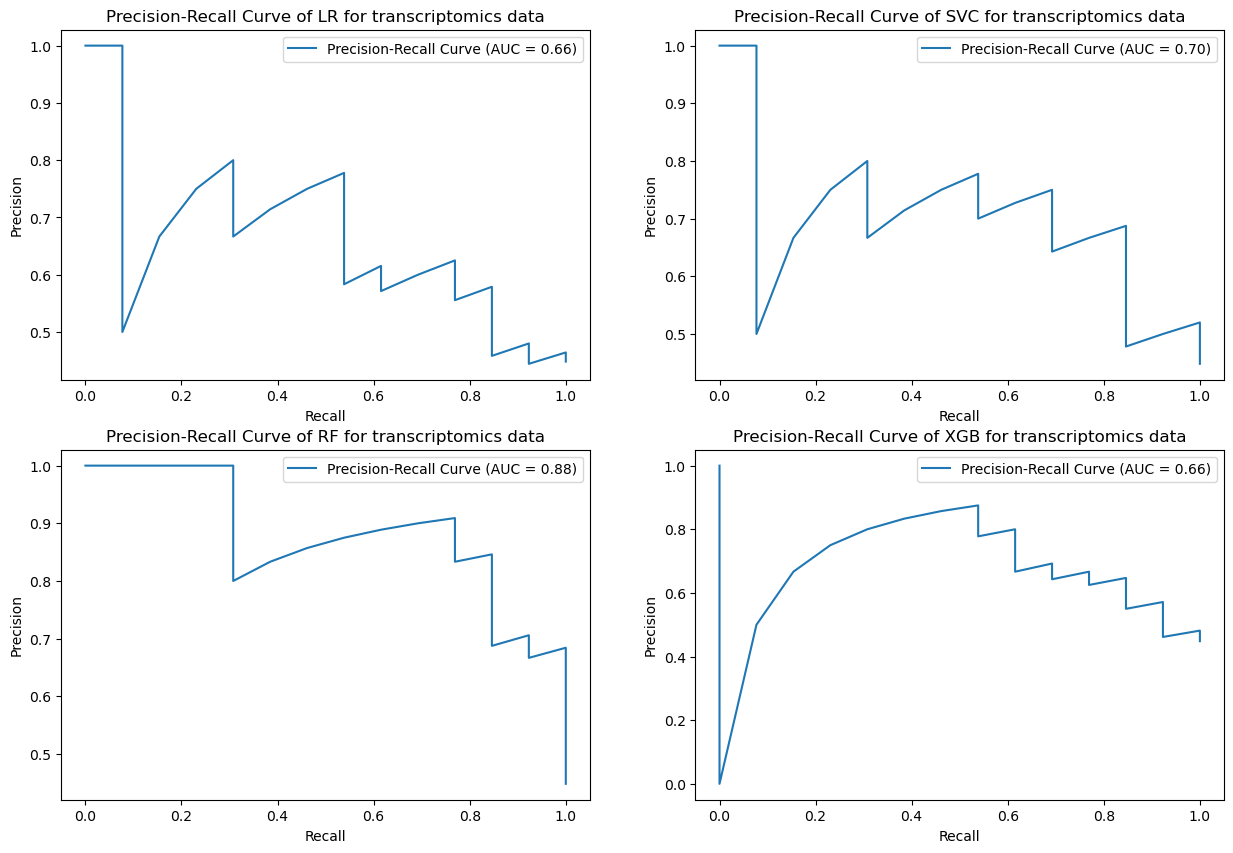

In [73]:
#PR Curves for transcriptomics data
fig, axis = plt.subplots(2, 2, figsize=(15, 10))

mods = ["LR","SVC","RF","XGB"]
axes = [axis[0,0], axis[0,1], axis[1,0], axis[1,1]]

for i in range(4):
    X_train, X_test, y_train, y_test = train_test_split(X1_stand, Y1, test_size=0.2, random_state=42)
    models[i].fit(X_train, y_train)
    y_scores = models[i].predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    auc_score = auc(recall, precision)
    
    axes[i].plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_title(f'Precision-Recall Curve of {mods[i]} for transcriptomics data')
    axes[i].legend()

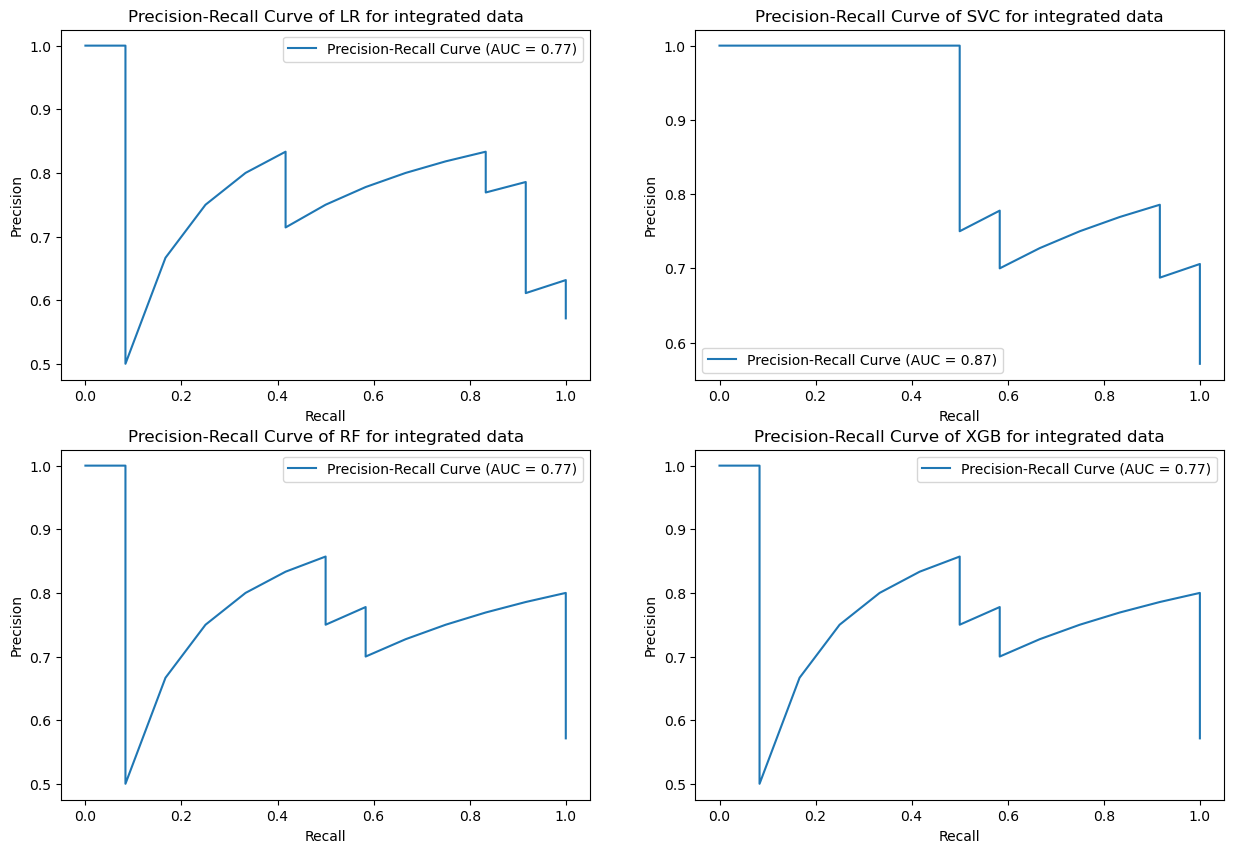

In [75]:
#PR Curves for integrated data
fig, axis = plt.subplots(2, 2, figsize=(15, 10))

mods = ["LR","SVC","RF","XGB"]
axes = [axis[0,0], axis[0,1], axis[1,0], axis[1,1]]

for i in range(4):
    X_train, X_test, y_train, y_test = train_test_split(X2_stand, Y2, test_size=0.2, random_state=42)
    models[i].fit(X_train, y_train)
    y_scores = models[i].predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    auc_score = auc(recall, precision)
    
    axes[i].plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_title(f'Precision-Recall Curve of {mods[i]} for integrated data')
    axes[i].legend()